### Random forest classifier

The theory for building a random forest model for classification problems. The image below shows some basic terminology and a sketch of a random forest with many decision trees.

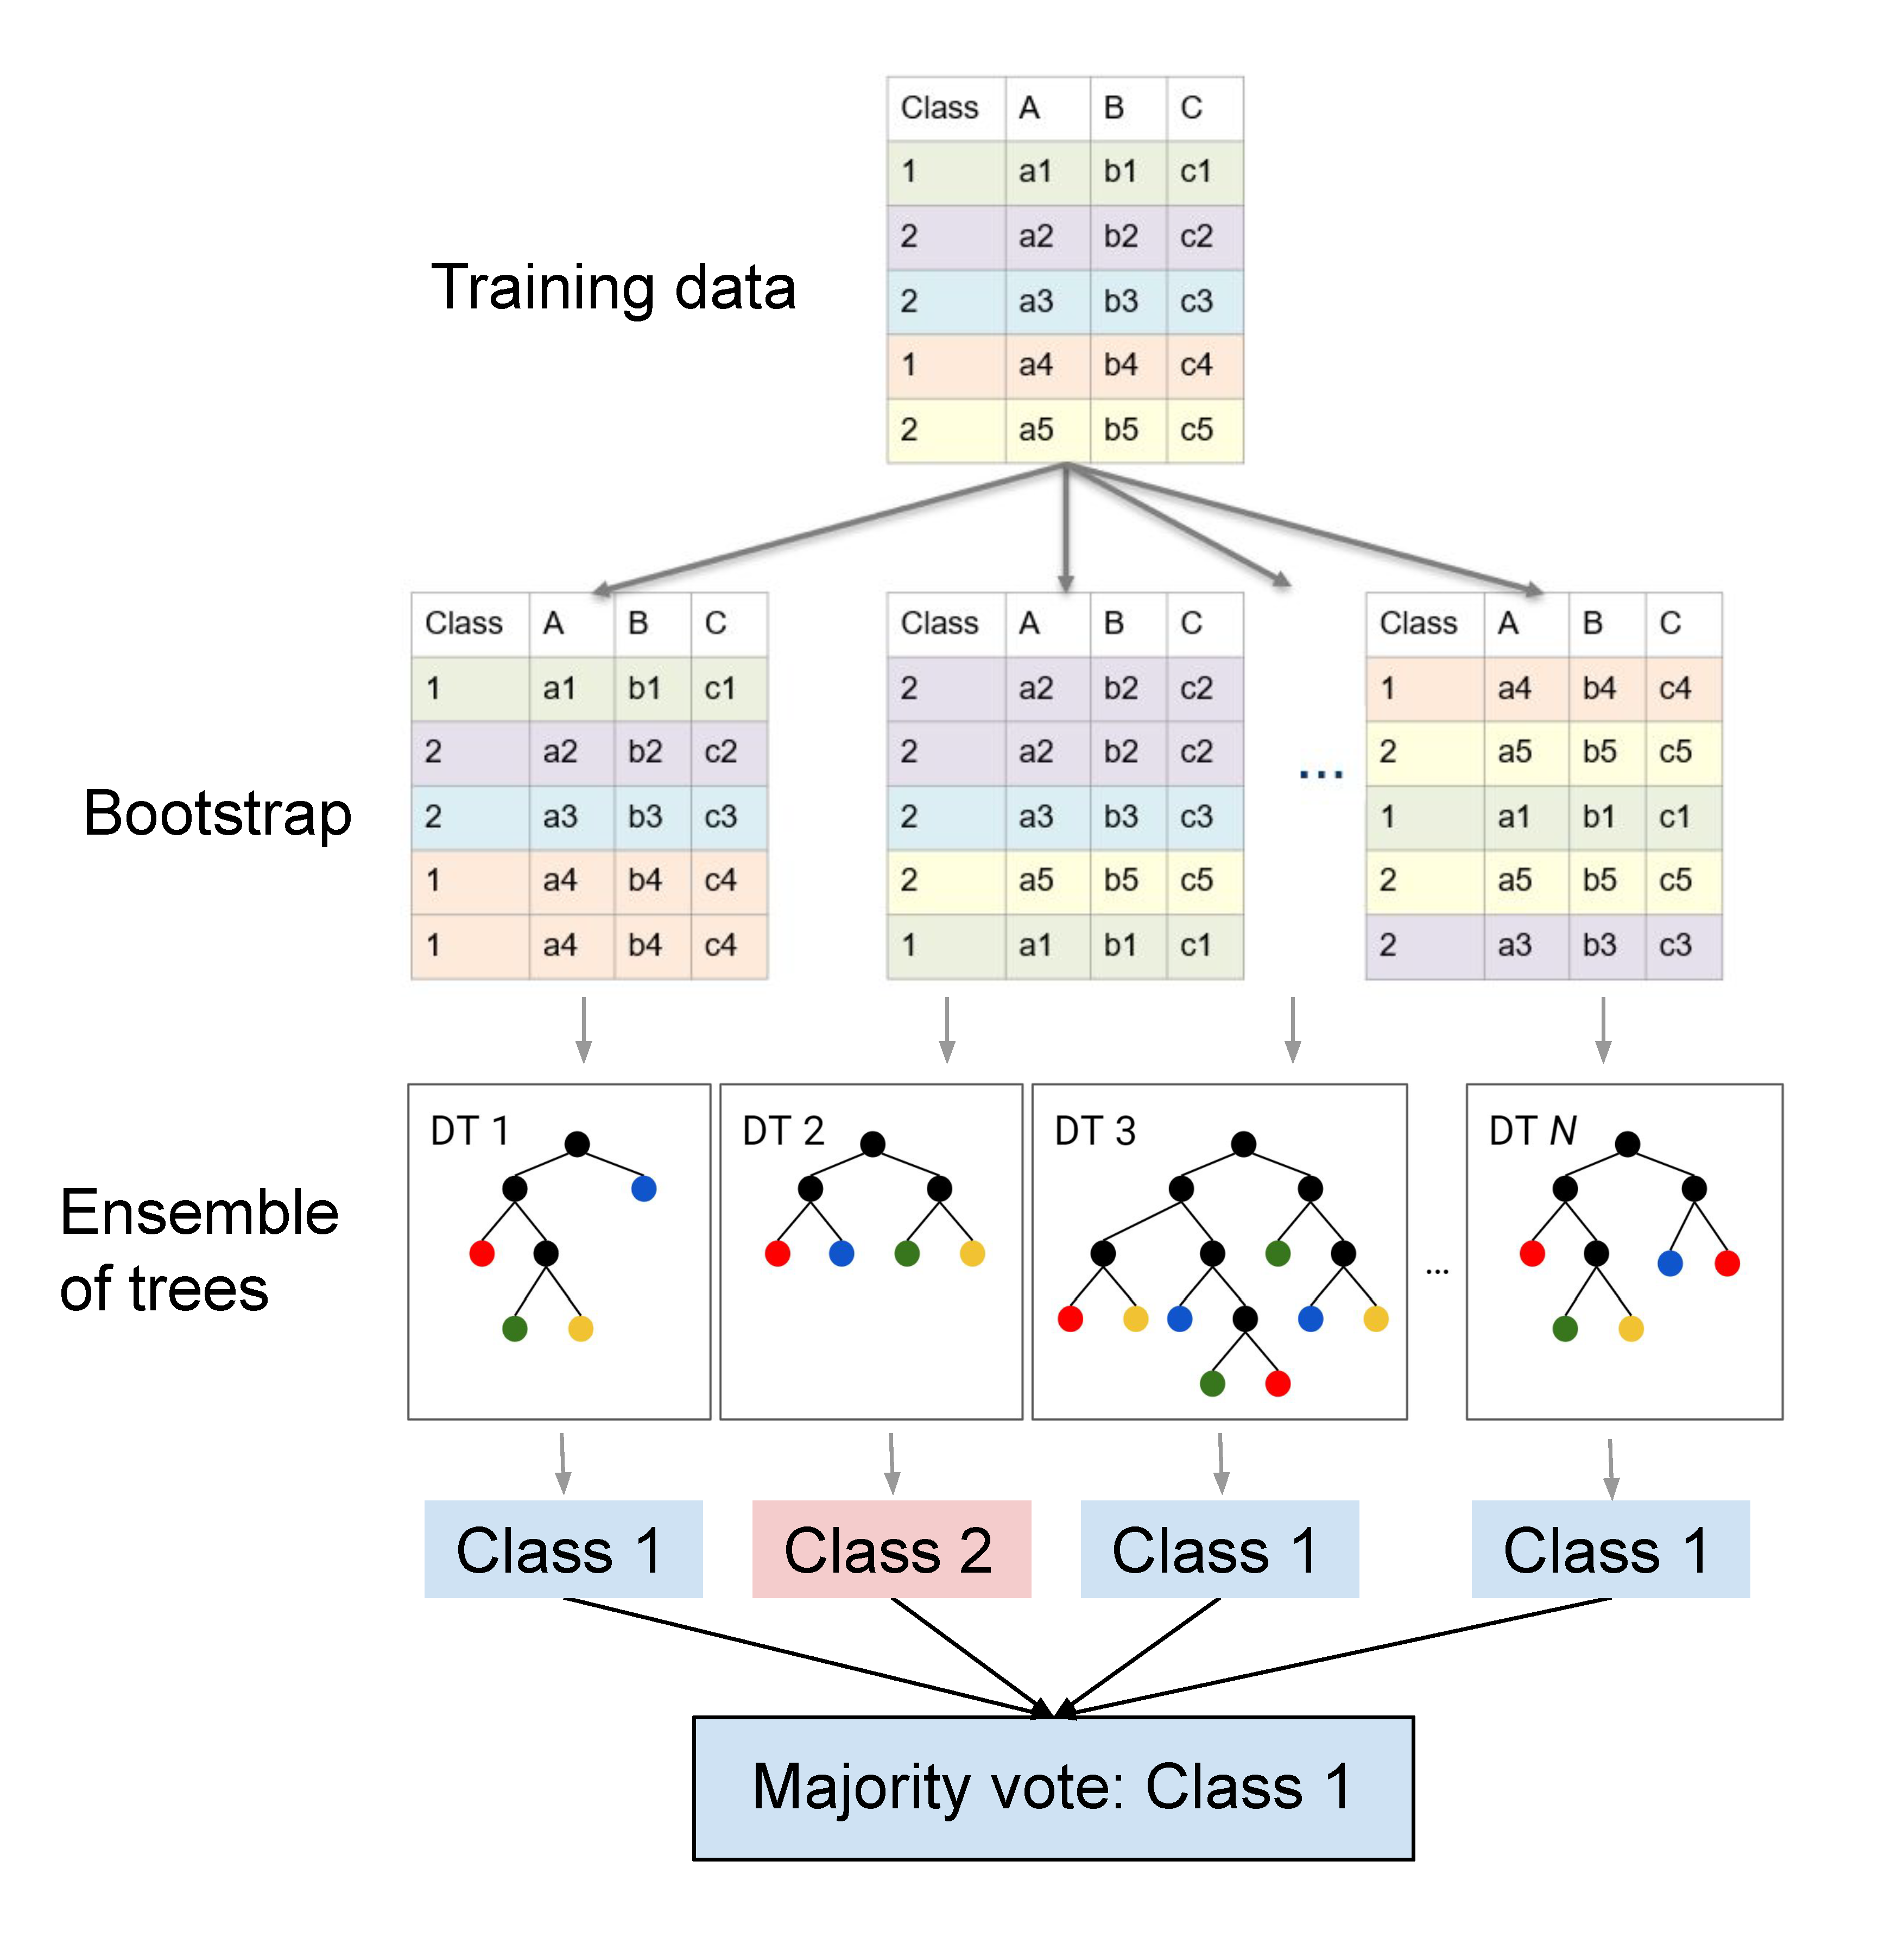

Image from: https://pages.cms.hu-berlin.de/EOL/geo_rs/S08_Image_classification2.html

In [1]:
import numpy as np
import pandas as pd
from decision_tree_classifier_modified import DecisionTreeClassifierModified

The basic idea of the random forest model is to train multiple decision tree models and combine their predictions, making it a so-called 'ensemble learning method'. In the case of a classification problem, the final prediction made by the forest is determined by a majority vote of all tree predictions. Combining many trees like this is beneficial because a decision tree tends to overfit to the data, especially if it grows to a large depth. By training many trees on random subsets of the data, allowing for more variety, this overfitting can be prevented.

Two types of randomness are introduced. The first is that we take a random sample (with replacement) of the data to train each tree with, called bootstrap aggregating or bagging. The second is that we take a random subset of features at each node within the tree. Note that the second one requires a modified decision tree algorithm! This is implemented in decision_tree_classifier_modified.py, but is still largely the same as the normal decision tree algorithm.

The benefit of adding these two types of randomness is to increase variety in trees. Training on different data simply increases diversity as different trees might work best on each set. Averaging the predictions of trees based on different data also decreases the variance of the overall model, as the errors of individual trees are smoothed over. This prevents overfitting too.
Training with random features at each node increases diversity a lot by ensuring that trees do not constantly pick the same features to split on. Despite a single feature potentially increasing the score the most, getting different features creates more different paths so that more relationships in the data can be captured. Additionally, this reduces correlation between trees, so that they are less likely to make the same mistakes.

We then implement the bagging algorithm here. So the goal is to take random samples with replacement of the data. The 'with replacement' part means that a single entry in the data may appear more than once in the bagged data. The point of this is that all bootstraps are unique, as they are the same size of the original dataset, so can only differ by leaving some points out and repeating others. There is of course also a benefit to this though, as each tree has different repeated data, so that in a sense each tree focuses on a different aspect of the data. Each tree then learn certain details about the data, so that when they are put together and their knowledge is combined, they can make better predictions.

In [ ]:
def create_bootstrap_samples(X, y, n_estimators, random_state=42):
    """
    Create the bootstrap samples of the given data.
    
    Parameters:
    X (DataFrame): The original dataset.
    y (Series): The labels corresponding to the dataset.
    n_estimators (int): The number of bootstrap samples to create
                          (equal to the number of trees in the forest).
    random_state (int): Seed for reproducibility. Defaults to 42.
    
    Returns:
    list: The bootstrap samples of the data.
    """
    if random_state is not None:
        np.random.seed(random_state)
    sample_size = X.shape[0]
    bootstrap_samples = []

    for _ in range(n_estimators):
        # Generate a random sample with replacement
        sample_indices = np.random.choice(sample_size, size=sample_size, replace=True)
        X_sample, y_sample = X.iloc[sample_indices], y.iloc[sample_indices]
        bootstrap_samples.append( (X_sample, y_sample) )
    
    return bootstrap_samples

test_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6],
    'feature2': [0, 1, 0, 1, 0, 1],
    'label': [1, 1, 1, 0, 0, 0]
    })
X = test_data[['feature1', 'feature2']]
y = test_data['label']
n_estimators = 2
bootstrap_samples_list = create_bootstrap_samples(X, y, n_estimators)
bootstrap_samples_list

[(   feature1  feature2
  3         4         1
  4         5         0
  2         3         0
  4         5         0
  4         5         0
  1         2         1,
  3    0
  4    0
  2    1
  4    0
  4    0
  1    1
  Name: label, dtype: int64),
 (   feature1  feature2
  2         3         0
  2         3         0
  2         3         0
  4         5         0
  3         4         1
  2         3         0,
  2    1
  2    1
  2    1
  4    0
  3    0
  2    1
  Name: label, dtype: int64)]

With the bagging method and modified decision tree algorithm we can then construct the forest. With each decision tree trained, we then make a prediction of the labels by a majority vote of all the trees.

In [ ]:
def build_forest(bootstrap_samples, n_estimators, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 verbose=False, threshold=0.0, num_features=None, random_state=42):
    """
    Build the random forest from a decision tree for each bootstrap sample.
    
    Parameters:
    bootstrap_samples (list): The list of bootstrap samples.
    n_estimators (int): The number of trees in the forest.
    
    Returns:
    list: The random forest (list of decision trees).
    """
    forest = []
    
    for i in range(n_estimators):
        X_sample, y_sample = bootstrap_samples[i]
        
        # Train a decision tree on the bootstrap sample
        tree = DecisionTreeClassifierModified(max_depth=max_depth,
                                               min_samples_split=min_samples_split,
                                               min_samples_leaf=min_samples_leaf,
                                               verbose=verbose,
                                               threshold=threshold,
                                               num_features=num_features,
                                               random_state=random_state)
        tree.fit(X_sample, y_sample)
        forest.append(tree)
    
    return forest

def predict(X, forest):
    """
    Make predictions using the random forest.
    
    Parameters:
    X (DataFrame): The data to make predictions on.
    forest (list): The random forest (list of decision trees).

    Returns:
    array-like: The predicted labels for the input data.
    """
    predictions = np.array([tree.predict(X) for tree in forest])
    # Use majority voting
    forest_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    return forest_predictions

In [15]:
# We do need 2 features to get good results, 1 is not enough with only two features total
forest = build_forest(bootstrap_samples_list, n_estimators, num_features=2)
predictions = predict(X, forest)
predictions

array([1, 1, 1, 0, 0, 0], dtype=int64)

In [16]:
# Finally add a score function just like for the decision tree
def score(y_true, y_pred):
    """
    Calculate the accuracy of predictions.
    
    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    
    Returns:
    float: Accuracy score.
    """
    return np.mean(y_true == y_pred)

accuracy = score(y, predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


Now for some more rigorous testing.

In [21]:
iris_data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv', header=None)
X = iris_data.drop(columns=[4])
y = iris_data[4]

# Map the labels to integers
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Do the Forest fit
bootstrap_samples_list = create_bootstrap_samples(X_train, y_train, n_estimators=5)
forest = build_forest(bootstrap_samples_list, n_estimators=5, max_depth=4)
y_pred = predict(X_test, forest)

accuracy = score(y_test, y_pred)
print("Iris dataset accuracy:", accuracy)

Iris dataset accuracy: 1.0


In [ ]:
# With 5 estimators and max_depth=4, it reaches the same accuracy of 1.0 as the decision tree with max_depth=4
# Test some different n_estimators
for n_estimators in [1, 2, 3, 4, 5]:
    bootstrap_samples_list = create_bootstrap_samples(X_train, y_train, n_estimators=n_estimators)
    forest = build_forest(bootstrap_samples_list, n_estimators=n_estimators, max_depth=4)
    y_pred = predict(X_test, forest)
    accuracy = score(y_test, y_pred)
    print(f"Accuracy with {n_estimators} estimators: {accuracy}")
# Somehow 2 estimators is slightly worse than the others, probably unfortunate randomness

Accuracy with 1 estimators: 1.0
Accuracy with 2 estimators: 0.9
Accuracy with 3 estimators: 1.0
Accuracy with 4 estimators: 1.0
Accuracy with 5 estimators: 1.0


In [24]:
# Compare with sklearn's RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
sklearn_forest = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=42)
sklearn_forest.fit(X_train, y_train)
sklearn_accuracy = sklearn_forest.score(X_test, y_test)
print("Sklearn RandomForestClassifier accuracy:", sklearn_accuracy)
# They have the same perfect accuracy, but sklearn is much faster

Sklearn RandomForestClassifier accuracy: 1.0


In [27]:
# Different dataset
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
X = pd.DataFrame(data=cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
bootstrap_samples_list = create_bootstrap_samples(X_train, y_train, n_estimators=10)
forest = build_forest(bootstrap_samples_list, n_estimators=10, max_depth=3)
y_pred = predict(X_test, forest)
accuracy = score(y_test, y_pred)
print("Breast cancer dataset accuracy:", accuracy)

Breast cancer dataset accuracy: 0.9824561403508771


In [28]:
sklearn_forest = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=42)
sklearn_forest.fit(X_train, y_train)
sklearn_accuracy = sklearn_forest.score(X_test, y_test)
print("Sklearn RandomForestClassifier accuracy:", sklearn_accuracy)

Sklearn RandomForestClassifier accuracy: 0.956140350877193


With 5 trees, both my implementation and sklearn are slightly worse than a single decision tree we did before.

With 10 trees, my result is the same as for the single tree, while sklearn gets slightly better than its single tree. 

My result is in both cases slightly better, but again slower.

In [29]:
# DrivenData Flu Shot data, preprocessed
X_train = pd.read_csv('../X_train_prep.csv')
y_train = pd.read_csv('../y_train.csv')['h1n1_vaccine']
X_test = pd.read_csv('../X_valid_prep.csv')
y_test = pd.read_csv('../y_valid.csv')['h1n1_vaccine']

bootstrap_samples_list = create_bootstrap_samples(X_train, y_train, n_estimators=5)
forest = build_forest(bootstrap_samples_list, n_estimators=5, max_depth=4)
y_pred = predict(X_test, forest)
accuracy = score(y_test, y_pred)
print("Flu Shot dataset accuracy:", accuracy)

Flu Shot dataset accuracy: 0.8011980531636091


In [ ]:
sklearn_forest = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=42)
sklearn_forest.fit(X_train, y_train)
sklearn_accuracy = sklearn_forest.score(X_test, y_test)
print("Sklearn RandomForestClassifier accuracy:", sklearn_accuracy)
# Here sklearn is slightly better, but also much faster (almost 1 minute vs less than 1 second)

Sklearn RandomForestClassifier accuracy: 0.8038187944590042


In the test cases it is clear that our implementation generates good results, that are similar to the model from sklearn, just like we saw for the decision tree. The only downside is that it is slower than sklearn, especially now that we have to train multiple trees, so for very large datasets it's likely not feasible to get results in a reasonable amount of time.